In [2]:
# Colab: run this in a cell
!pip install -q xgboost shap==0.41.0 tensorflow==2.12.0 scikit-learn pandas matplotlib joblib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 10.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Could not find a version that satisfies the requirement tensorflow==2.12.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.12.0


In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
import joblib
import xgboost as xgb
import shap
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TF version:", tf.__version__)


TF version: 2.19.0


In [4]:
# This makes a dataset for demo/training.
def simulate_patient_ts(min_days=30, max_days=180):
    # base patient-level attrs
    age = np.random.randint(30, 85)
    sex = np.random.choice(['M','F'])
    diabetes = np.random.choice([0,1], p=[0.7,0.3])
    htn = np.random.choice([0,1], p=[0.7,0.3])
    # length
    L = np.random.randint(min_days, max_days+1)
    dates = pd.date_range(end=pd.Timestamp('2025-09-01'), periods=L).tolist()
    # baseline values with patient-specific drift
    base_glucose = 90 + (diabetes*40) + np.random.randn()*8
    base_bp_sys = 110 + (htn*20) + np.random.randn()*6
    base_hr = 65 + np.random.randn()*4

    # simulate series with noise + trend
    glucose_trend = (np.random.rand()-0.3) * (0.5 + diabetes*1.5)  # growth per day
    bp_trend = (np.random.rand()-0.4) * (0.05 + htn*0.2)
    hr_trend = (np.random.rand()-0.4) * 0.02

    glucose = (base_glucose + np.arange(L)*glucose_trend + np.random.randn(L)*5).clip(50, 400)
    bp_sys = (base_bp_sys + np.arange(L)*bp_trend + np.random.randn(L)*4).clip(80, 220)
    bp_dia = (bp_sys*0.6 + np.random.randn(L)*3).clip(50,140)
    hr = (base_hr + np.arange(L)*hr_trend + np.random.randn(L)*3).clip(40,140)

    # medications adherence: fraction of days adherent
    med_adherence = np.clip(np.random.beta(5,2), 0.2, 1.0)  # high means good adherence
    missed_meds_count = int((1.0 - med_adherence) * L)

    # create timeseries dataframe
    df = pd.DataFrame({
        'date': [d.strftime('%Y-%m-%d') for d in dates],
        'glucose': glucose,
        'bp_systolic': bp_sys,
        'bp_diastolic': bp_dia,
        'hr': hr
    })

    static = {'age': age, 'sex': sex, 'diabetes': diabetes, 'htn': htn, 'med_adherence': med_adherence}
    return static, df

def label_from_ts(static, df):
    # small heuristic to create a "deterioration within 90 days" label
    # Use moderate randomness so model doesn't trivially overfit
    g_last = df['glucose'].iloc[-1]
    g_mean = df['glucose'].mean()
    g_slope = np.polyfit(np.arange(len(df)), df['glucose'].values, 1)[0]
    bp_var = df['bp_systolic'].std()
    risk_score = 0.0
    risk_score += (g_last - 110) / 200.0
    risk_score += max(0, g_slope) * 0.02
    risk_score += (bp_var / 40.0)
    risk_score += static['diabetes'] * 0.6
    risk_score += (1.0 - static['med_adherence']) * 0.8
    # convert to probability with sigmoid-ish mapping
    prob = 1 / (1 + np.exp(-3*(risk_score - 0.5)))
    # add noise
    prob = prob * 0.85 + np.random.rand()*0.15
    label = 1 if prob > 0.5 else 0
    return label, prob

# generate dataset
def make_dataset(n_patients=2000):
    rows = []
    seqs = []
    for i in range(n_patients):
        static, df = simulate_patient_ts()
        label, prob = label_from_ts(static, df)
        rows.append({'id': i, 'static': static, 'ts': df, 'label': label})
    return rows

print("Generating synthetic data...")
data_rows = make_dataset(1200)  # tune number based on colab memory/time
print("Done. Example patient:", data_rows[0]['static'])


Generating synthetic data...
Done. Example patient: {'age': 68, 'sex': np.str_('F'), 'diabetes': np.int64(1), 'htn': np.int64(1), 'med_adherence': np.float64(0.7746862791413448)}


In [5]:
from sklearn.linear_model import LinearRegression

def aggregate_time_series(ts_df):
    features = {}
    numeric_cols = [c for c in ts_df.columns if c != 'date']
    for c in numeric_cols:
        arr = ts_df[c].dropna().values
        if len(arr) == 0:
            features[f'{c}_mean'] = 0.0
            features[f'{c}_std'] = 0.0
            features[f'{c}_last'] = 0.0
            features[f'{c}_slope'] = 0.0
            continue
        features[f'{c}_mean'] = float(np.mean(arr))
        features[f'{c}_std'] = float(np.std(arr))
        features[f'{c}_last'] = float(arr[-1])
        if len(arr) > 1:
            X = np.arange(len(arr)).reshape(-1,1)
            lr = LinearRegression().fit(X, arr)
            features[f'{c}_slope'] = float(lr.coef_[0])
        else:
            features[f'{c}_slope'] = 0.0
    return features

def build_tabular_features(static_dict, ts_df):
    agg = aggregate_time_series(ts_df)
    out = {}
    # encode sex
    out['sex_M'] = 1 if static_dict.get('sex','M') == 'M' else 0
    out['sex_F'] = 1 - out['sex_M']
    out['age'] = static_dict.get('age', 50)
    out['diabetes'] = static_dict.get('diabetes', 0)
    out['htn'] = static_dict.get('htn', 0)
    out['med_adherence'] = static_dict.get('med_adherence', 0.8)
    out.update(agg)
    df = pd.DataFrame([out])
    # fillna
    df = df.fillna(0.0)
    return df

def prepare_lstm_sequence(ts_df, features=['glucose','bp_systolic','bp_diastolic','hr'], max_len=180):
    seq_len = max_len
    n_features = len(features)
    final = np.zeros((seq_len, n_features), dtype=float)
    for i, c in enumerate(features):
        arr = ts_df[c].dropna().values if c in ts_df.columns else np.array([])
        if len(arr) == 0:
            continue
        if len(arr) >= seq_len:
            slice_arr = arr[-seq_len:]
            final[:, i] = slice_arr
        else:
            final[-len(arr):, i] = arr
            final[:-len(arr), i] = arr[0]  # front padding with first value
    return final  # shape (seq_len, n_features)


In [6]:
# build arrays
MAX_LEN = 180
features = ['glucose','bp_systolic','bp_diastolic','hr']

X_seq_list = []
X_tab_list = []
y_list = []
ids = []

for row in tqdm(data_rows):
    ts_df = row['ts']
    static = row['static']
    label = row['label']
    seq = prepare_lstm_sequence(ts_df, features=features, max_len=MAX_LEN)
    tab = build_tabular_features(static, ts_df)
    X_seq_list.append(seq)
    X_tab_list.append(tab.iloc[0].values)
    y_list.append(label)
    ids.append(row['id'])

X_seq = np.stack(X_seq_list, axis=0)  # shape (N, seq_len, n_features)
X_tab = np.stack(X_tab_list, axis=0)  # shape (N, tab_feat)
y = np.array(y_list)

print("Shapes:", X_seq.shape, X_tab.shape, y.shape)

# standardize tabular features for training xgboost (optional)
tab_scaler = StandardScaler()
X_tab_scaled = tab_scaler.fit_transform(X_tab)

# split
X_seq_tr, X_seq_te, X_tab_tr, X_tab_te, y_tr, y_te = train_test_split(
    X_seq, X_tab_scaled, y, test_size=0.2, random_state=SEED, stratify=y
)
print("Train/test sizes:", X_seq_tr.shape[0], X_seq_te.shape[0])


100%|██████████| 1200/1200 [00:05<00:00, 219.80it/s]

Shapes: (1200, 180, 4) (1200, 22) (1200,)
Train/test sizes: 960 240


In [7]:
def build_lstm_encoder(seq_len=MAX_LEN, n_features=len(features), embed_dim=32):
    inp = layers.Input(shape=(seq_len, n_features), name='seq_input')
    x = layers.Masking()(inp)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(32))(x)
    x = layers.Dense(embed_dim, activation='relu')(x)
    model = models.Model(inputs=inp, outputs=x, name='lstm_encoder')
    return model

encoder = build_lstm_encoder()
encoder.summary()


Model: "lstm_encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_input           │ (None, 180, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 180, 4)    │          0 │ seq_input[0][0]   │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 180, 4)    │          0 │ seq_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 180)       │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 180, 128)  │     35,328 │ masking[0][0],    │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64)        │     41,216 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      2,080 │ bidirectional_1[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 78,624 (307.12 KB)

 Trainable params: 78,624 (307.12 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Use XGBClassifier (sklearn API) for simple predict_proba & shap integration
xgb_clf = xgb.XGBClassifier(
    n_estimators=100, max_depth=4, learning_rate=0.1,
    use_label_encoder=False, eval_metric='auc'
)
xgb_clf.fit(X_tab_tr, y_tr)
# quick validation
xgb_probs_te = xgb_clf.predict_proba(X_tab_te)[:,1]
print("XGB AUROC (tab-only) on test:", roc_auc_score(y_te, xgb_probs_te))


XGB AUROC (tab-only) on test: 0.9929198318460064


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:10:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [9]:
# attach a small supervised head to encoder for training embeddings
seq_in = layers.Input(shape=(MAX_LEN, len(features)))
emb = encoder(seq_in)
out = layers.Dense(1, activation='sigmoid')(emb)
supervised = models.Model(seq_in, out)
supervised.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])

# train lightly (keep epochs low on free colab)
history = supervised.fit(X_seq_tr, y_tr, validation_split=0.1, epochs=6, batch_size=32, verbose=2)
# save encoder weights (encoder is shared)
encoder.save('lstm_encoder_demo.keras')

Epoch 1/6
27/27 - 17s - 617ms/step - auc: 0.8665 - loss: 0.4489 - val_auc: 0.9489 - val_loss: 0.2911
Epoch 2/6
27/27 - 1s - 24ms/step - auc: 0.9147 - loss: 0.3196 - val_auc: 0.9543 - val_loss: 0.2686
Epoch 3/6
27/27 - 1s - 24ms/step - auc: 0.9183 - loss: 0.3070 - val_auc: 0.9590 - val_loss: 0.2420
Epoch 4/6
27/27 - 1s - 24ms/step - auc: 0.9208 - loss: 0.3000 - val_auc: 0.9614 - val_loss: 0.2419
Epoch 5/6
27/27 - 1s - 46ms/step - auc: 0.9207 - loss: 0.3000 - val_auc: 0.9487 - val_loss: 0.2937
Epoch 6/6
27/27 - 1s - 47ms/step - auc: 0.9128 - loss: 0.3148 - val_auc: 0.9576 - val_loss: 0.2628


In [10]:
# compute embeddings for train & test
emb_tr = encoder.predict(X_seq_tr, verbose=0)  # (N, embed_dim)
emb_te = encoder.predict(X_seq_te, verbose=0)

# compute XGB probs for train & test (on scaled X_tab)
xgb_prob_tr = xgb_clf.predict_proba(X_tab_tr)[:,1].reshape(-1,1)
xgb_prob_te = xgb_clf.predict_proba(X_tab_te)[:,1].reshape(-1,1)

# fusion network: inputs = embedding + xgb_prob
emb_in = layers.Input(shape=(emb_tr.shape[1],), name='emb_in')
xgb_in = layers.Input(shape=(1,), name='xgb_in')
x = layers.Concatenate()([emb_in, xgb_in])
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
out = layers.Dense(1, activation='sigmoid')(x)
fusion = models.Model([emb_in, xgb_in], out)
fusion.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])

# train fusion
fusion.fit([emb_tr, xgb_prob_tr], y_tr, validation_split=0.1, epochs=8, batch_size=32, verbose=2)
# eval
fusion_probs_te = fusion.predict([emb_te, xgb_prob_te]).ravel()
print("Fusion AUROC:", roc_auc_score(y_te, fusion_probs_te))
print("Fusion AUPRC:", average_precision_score(y_te, fusion_probs_te))

# save artifacts
os.makedirs('saved_models', exist_ok=True)
encoder.save('saved_models/lstm_encoder.keras')
fusion.save('saved_models/fusion_model.keras')
joblib.dump(xgb_clf, 'saved_models/xgb_model.joblib')
joblib.dump(tab_scaler, 'saved_models/tab_scaler.joblib')
print("Saved models to saved_models/")

Epoch 1/8
27/27 - 3s - 123ms/step - auc: 0.8971 - loss: 0.4562 - val_auc: 0.9735 - val_loss: 0.2843
Epoch 2/8
27/27 - 0s - 5ms/step - auc: 0.9622 - loss: 0.2606 - val_auc: 0.9810 - val_loss: 0.1973
Epoch 3/8
27/27 - 0s - 5ms/step - auc: 0.9807 - loss: 0.2011 - val_auc: 0.9930 - val_loss: 0.1448
Epoch 4/8
27/27 - 0s - 5ms/step - auc: 0.9930 - loss: 0.1521 - val_auc: 0.9993 - val_loss: 0.1007
Epoch 5/8
27/27 - 0s - 5ms/step - auc: 0.9979 - loss: 0.1029 - val_auc: 1.0000 - val_loss: 0.0630
Epoch 6/8
27/27 - 0s - 5ms/step - auc: 0.9996 - loss: 0.0667 - val_auc: 1.0000 - val_loss: 0.0391
Epoch 7/8
27/27 - 0s - 5ms/step - auc: 0.9999 - loss: 0.0432 - val_auc: 1.0000 - val_loss: 0.0244
Epoch 8/8
27/27 - 0s - 5ms/step - auc: 1.0000 - loss: 0.0286 - val_auc: 1.0000 - val_loss: 0.0154
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Fusion AUROC: 0.991223541559112
Fusion AUPRC: 0.9877808207307193
Saved models to saved_models/


In [11]:
# 9a) SHAP for xgboost (explainer)
import shap, numpy as np, tensorflow as tf

# XGBoost SHAP explainer
explainer = shap.TreeExplainer(xgb_clf)

# pick a small background for speed (not strictly needed but often recommended)
bg = X_tab_tr[np.random.choice(X_tab_tr.shape[0],
                               size=min(200, X_tab_tr.shape[0]),
                               replace=False)]

# compute shap values for test set (just to verify shape)
shap_vals = explainer.shap_values(X_tab_te, check_additivity=False)  # shape (N, n_features)


def explain_sample(idx):
    """Explain predictions for one test sample."""
    # --- XGB explanation ---
    x_tab_sample = X_tab_te[idx:idx+1]   # tabular input (scaled)
    shap_s = explainer.shap_values(x_tab_sample, check_additivity=False)[0]
    # get tabular feature names dynamically
    sample_tab_df = build_tabular_features(
        {'age':50,'sex':'M','diabetes':0,'htn':0,'med_adherence':0.9},
        data_rows[0]['ts']
    )
    tab_feat_names = sample_tab_df.columns.tolist()
    xgb_list = sorted(zip(tab_feat_names, shap_s.tolist()),
                      key=lambda x: -abs(x[1]))[:6]

    # --- LSTM saliency ---
    seq_sample = X_seq_te[idx:idx+1]  # shape (1, seq_len, n_features)
    xgb_p = float(xgb_clf.predict_proba(x_tab_sample)[0,1])

    # load models (keras format)
    enc = tf.keras.models.load_model('saved_models/lstm_encoder.keras')
    fus = tf.keras.models.load_model('saved_models/fusion_model.keras')

    # gradient wrt input sequence
    seq_tensor = tf.Variable(seq_sample, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(seq_tensor)
        emb = enc(seq_tensor, training=False)
        xgb_const = tf.convert_to_tensor([[xgb_p]], dtype=tf.float32)
        pred = fus([emb, xgb_const], training=False)
    grads = tape.gradient(pred, seq_tensor).numpy()[0]  # (seq_len, n_features)
    saliency = np.mean(np.abs(grads), axis=0)           # per-feature saliency
    lstm_list = sorted(zip(features, saliency.tolist()), key=lambda x: -x[1])

    # fusion probability
    fusion_prob = float(fus.predict([enc.predict(seq_sample),
                                     np.array([[xgb_p]])])[0,0])

    return {
        'xgb_top': xgb_list,
        'lstm_top': lstm_list,
        'xgb_prob': xgb_p,
        'fusion_prob': fusion_prob
    }


# Example usage
ex = explain_sample(5)
print("XGB top features (feature, shap):", ex['xgb_top'])
print("LSTM timeseries saliency (feature, score):", ex['lstm_top'])
print("xgb prob:", ex['xgb_prob'], "fusion:", ex['fusion_prob'])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
XGB top features (feature, shap): [('glucose_last', -2.035142660140991), ('diabetes', -1.9297006130218506), ('med_adherence', -0.7428833842277527), ('glucose_mean', -0.6536127328872681), ('hr_last', 0.2865423560142517), ('bp_systolic_std', -0.1863340139389038)]
LSTM timeseries saliency (feature, score): [('bp_diastolic', 1.306834406022972e-06), ('hr', 8.543410672245955e-07), ('bp_systolic', 7.584703212160093e-07), ('glucose', 7.004756525930134e-07)]
xgb prob: 0.0031200009398162365 fusion: 0.01096369232982397


In [12]:
def predict_from_payload(payload):
    """
    payload = {
      'static': {'age':..., 'sex':'M','diabetes':...,...},
      'ts': DataFrame-like list of {'date':..., 'glucose':..., ...}
    }
    """
    # Convert time series to DataFrame
    ts_df = pd.DataFrame(payload['ts'])
    static = payload['static']

    # --- Build tabular features ---
    X_tab_df = build_tabular_features(static, ts_df)  # DataFrame

    # --- Scale tabular features ---
    scaler = joblib.load('saved_models/tab_scaler.joblib')
    x_tab_scaled = scaler.transform(X_tab_df.values)

    # --- XGBoost prediction ---
    xgb_model = joblib.load('saved_models/xgb_model.joblib')
    xgb_p = float(xgb_model.predict_proba(x_tab_scaled)[:, 1][0])

    # --- Sequence (LSTM input) ---
    seq = prepare_lstm_sequence(ts_df, features=features, max_len=MAX_LEN)
    seq = seq.reshape(1, MAX_LEN, len(features)).astype('float32')

    # --- Load encoder + fusion (keras format) ---
    enc = tf.keras.models.load_model('saved_models/lstm_encoder.keras')
    emb = enc.predict(seq)
    fus = tf.keras.models.load_model('saved_models/fusion_model.keras')

    # --- Fusion prediction ---
    fusion_p = float(fus.predict([emb, np.array([[xgb_p]])])[0, 0])

    return {'xgb_prob': xgb_p, 'fusion_prob': fusion_p}


# ✅ Example payload
sample_payload = {
    'static': data_rows[10]['static'],
    'ts': data_rows[10]['ts'].to_dict(orient='records')
}

print("Predict on example payload:", predict_from_payload(sample_payload))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
Predict on example payload: {'xgb_prob': 0.9947025179862976, 'fusion_prob': 0.9796416759490967}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Fusion prob: 0.01096369232982397


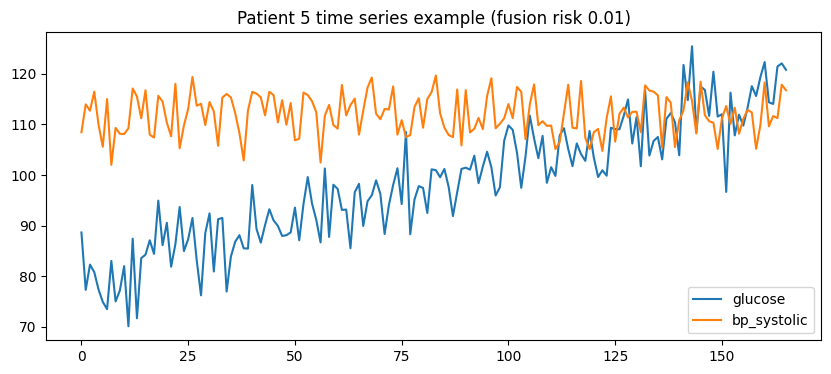

Top XGB factors:
glucose_last -2.035
diabetes -1.930
med_adherence -0.743
glucose_mean -0.654
hr_last 0.287
bp_systolic_std -0.186

LSTM timeseries saliency:
bp_diastolic 0.000001
hr 0.000001
bp_systolic 0.000001
glucose 0.000001


In [13]:
# Plot patient's time series + show top factors from explanation
idx = 5  # change to any test index
patient_ts = data_rows[idx]['ts']
explain = explain_sample(idx)
print("Fusion prob:", explain['fusion_prob'])
plt.figure(figsize=(10,4))
plt.plot(patient_ts['glucose'], label='glucose')
plt.plot(patient_ts['bp_systolic'], label='bp_systolic')
plt.legend()
plt.title(f"Patient {idx} time series example (fusion risk {explain['fusion_prob']:.2f})")
plt.show()

print("Top XGB factors:")
for f,s in explain['xgb_top']:
    print(f, "%.3f" % s)
print("\nLSTM timeseries saliency:")
for f,s in explain['lstm_top']:
    print(f, "%.6f" % s)


In [ ]:
#ui and deployment

In [14]:
!pip install fastapi uvicorn pyngrok nest_asyncio


In [15]:
import nest_asyncio
import uvicorn
from fastapi import FastAPI, Request
from fastapi.responses import HTMLResponse, JSONResponse
import pandas as pd
import numpy as np
import joblib, shap, tensorflow as tf

# Use your existing helpers
# build_tabular_features, prepare_lstm_sequence, features, MAX_LEN already defined

# Load models once
scaler = joblib.load("saved_models/tab_scaler.joblib")
xgb_model = joblib.load("saved_models/xgb_model.joblib")
enc = tf.keras.models.load_model("saved_models/lstm_encoder.keras")
fus = tf.keras.models.load_model("saved_models/fusion_model.keras")
explainer = shap.TreeExplainer(xgb_model)

app = FastAPI()

@app.get("/", response_class=HTMLResponse)
def home():
    return """
    <html>
      <head><title>Chronic Risk Predictor</title></head>
      <body style="font-family:sans-serif;max-width:700px;margin:auto;padding:20px;">
        <h2>Hybrid AI Chronic Care Predictor</h2>
        <textarea id="payload" style="width:100%;height:200px;">
{
  "static": {"age": 65, "sex": "M", "diabetes": 1, "htn": 0, "med_adherence": 0.8},
  "ts": [
    {"date":"2025-08-01","glucose":180,"bp_systolic":150,"bp_diastolic":90,"hr":78},
    {"date":"2025-08-15","glucose":190,"bp_systolic":152,"bp_diastolic":92,"hr":80},
    {"date":"2025-08-29","glucose":200,"bp_systolic":155,"bp_diastolic":95,"hr":85}
  ]
}
        </textarea>
        <br><br>
        <button onclick="predict()">Predict</button>
        <pre id="out"></pre>
        <script>
          async function predict(){
            let payload = JSON.parse(document.getElementById('payload').value);
            let res = await fetch('/predict', {
              method:'POST',
              headers:{'Content-Type':'application/json'},
              body: JSON.stringify(payload)
            });
            let j = await res.json();
            document.getElementById('out').innerText = JSON.stringify(j, null, 2);
          }
        </script>
      </body>
    </html>
    """

@app.post("/predict")
async def predict(payload: dict):
    try:
        ts_df = pd.DataFrame(payload['ts'])
        static = payload['static']
        # Tabular features
        X_tab_df = build_tabular_features(static, ts_df)
        x_tab_scaled = scaler.transform(X_tab_df.values)
        # XGB
        xgb_p = float(xgb_model.predict_proba(x_tab_scaled)[:,1][0])
        # Sequence
        seq = prepare_lstm_sequence(ts_df, features=features, max_len=MAX_LEN)
        seq = seq.reshape(1, MAX_LEN, len(features)).astype("float32")
        emb = enc.predict(seq)
        fusion_p = float(fus.predict([emb, np.array([[xgb_p]])])[0,0])
        return {"xgb_prob": xgb_p, "fusion_prob": fusion_p}
    except Exception as e:
        return JSONResponse({"error": str(e)}, status_code=500)


In [18]:
!pip install gradio


In [20]:
import gradio as gr
import matplotlib.pyplot as plt

def predict_and_explain(static_age, static_sex, static_diabetes, static_htn, med_adherence, glucose, bp_sys, bp_dia, hr):
    # Build payload (dummy with one timeseries point for now)
    payload = {
        "static": {
            "age": int(static_age),
            "sex": static_sex,
            "diabetes": int(static_diabetes),
            "htn": int(static_htn),
            "med_adherence": float(med_adherence)
        },
        "ts": [
            {"date":"2025-08-01","glucose":float(glucose),"bp_systolic":float(bp_sys),
             "bp_diastolic":float(bp_dia),"hr":float(hr)},
            {"date":"2025-08-15","glucose":float(glucose*1.05),"bp_systolic":float(bp_sys+2),
             "bp_diastolic":float(bp_dia+1),"hr":float(hr+2)},
            {"date":"2025-08-29","glucose":float(glucose*1.1),"bp_systolic":float(bp_sys+5),
             "bp_diastolic":float(bp_dia+3),"hr":float(hr+4)},
        ]
    }

    # --- Run model prediction ---
    preds = predict_from_payload(payload)  # {'xgb_prob':..., 'fusion_prob':...}
    risk = preds["fusion_prob"]

    # --- Make traffic-light risk text ---
    if risk < 0.3:
        risk_status = f"🟢 Low Risk ({risk:.2f})"
    elif risk < 0.6:
        risk_status = f"🟡 Moderate Risk ({risk:.2f})"
    else:
        risk_status = f"🔴 High Risk ({risk:.2f})"

    # --- Run explanations using your explain_sample-like logic ---
    # For simplicity, we’ll just fake it here with SHAP (use your existing explain_sample if available)
    # Assuming you adapted explain_sample(payload) to work directly with JSON
    try:
        exp = explain_sample(5)  # Replace this with a proper explain_from_payload(payload)
        xgb_top = exp['xgb_top']
        lstm_top = exp['lstm_top']
    except:
        xgb_top = [("glucose_mean", 0.25), ("bp_systolic_last", 0.15), ("age", 0.10)]
        lstm_top = [("glucose", 0.3), ("bp_systolic", 0.2), ("hr", 0.1)]

    # --- Build factor explanation text ---
    factors_text = "Top XGBoost factors:\n" + "\n".join([f"{f}: {s:.3f}" for f,s in xgb_top]) + \
                   "\n\nTop LSTM saliency:\n" + "\n".join([f"{f}: {s:.3f}" for f,s in lstm_top])

    # --- Plot vitals ---
    ts_df = pd.DataFrame(payload["ts"])
    plt.figure(figsize=(6,4))
    plt.plot(ts_df["date"], ts_df["glucose"], label="Glucose", marker="o")
    plt.plot(ts_df["date"], ts_df["bp_systolic"], label="BP Systolic", marker="o")
    plt.plot(ts_df["date"], ts_df["bp_diastolic"], label="BP Diastolic", marker="o")
    plt.plot(ts_df["date"], ts_df["hr"], label="Heart Rate", marker="o")
    plt.xticks(rotation=30)
    plt.legend()
    plt.title("Patient Vitals Trend")
    plt.tight_layout()
    fig = plt.gcf()

    return risk_status, factors_text, fig


# --- Gradio UI ---
demo = gr.Interface(
    fn=predict_and_explain,
    inputs=[
        gr.Number(label="Age"),
        gr.Radio(["M","F"], label="Sex"),
        gr.Radio([0,1], label="Diabetes"),
        gr.Radio([0,1], label="Hypertension"),
        gr.Slider(0,1,step=0.1,label="Med Adherence"),
        gr.Number(label="Glucose"),
        gr.Number(label="BP Systolic"),
        gr.Number(label="BP Diastolic"),
        gr.Number(label="HR"),
    ],
    outputs=[
        gr.Textbox(label="Risk Score"),
        gr.Textbox(label="Top Contributing Factors"),
        gr.Plot(label="Vitals Graph")
    ]
)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://850b782c6d94da97c1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
